In [2]:
import polars as pl
import numpy as np
import os
from bellman_filter_dfsv.filters.bellman_information import DFSVBellmanInformationFilter
from bellman_filter_dfsv.models.dfsv import DFSVParamsDataclass
from bellman_filter_dfsv.utils.optimization import run_optimization
from bellman_filter_dfsv.filters.particle import DFSVParticleFilter
from bellman_filter_dfsv.utils.optimization import FilterType
from bellman_filter_dfsv.utils.optimization_helpers import create_stable_initial_params
import time
import pandas as pd
import jax
import jax.numpy as jnp
import cloudpickle
import pickle
from pathlib import Path
from rich import print
jax.config.update("jax_enable_x64", True)
df =pl.read_csv("../../vw_returns_final.csv")
df.head()
df_with_date=pl.read_csv("../../vw_returns_final_with_date.csv")
# os.getcwd()
returns=df.to_jax()
N=95
K=5
T=returns.shape[0]

In [3]:
#Load pickle file
with open('pf_full_result_20250425_194312.pkl', 'rb') as f:
    result_bif = cloudpickle.load(f)
# bif_filter=DFSVBellmanInformationFilter(N,K)
bif_filter=DFSVParticleFilter(N,K,num_particles=10000)
bif_params=result_bif.final_params
print(round(bif_params.Phi_f,3))
filtered_states_bf,filtered_infos_bf,log_likelihood_bf=bif_filter.filter(bif_params,returns)
result_bif

[[ 0.428  0.025 -0.092 -0.189 -0.053]
 [ 0.019  0.498  0.015  0.022  0.01 ]
 [-0.09   0.019  0.455 -0.15  -0.046]
 [-0.231  0.034 -0.19   0.292 -0.128]
 [-0.052  0.01  -0.048 -0.102  0.468]]

OptimizerResult(filter_type=<FilterType.PF: 3>, optimizer_name='ArmijoBFGS', uses_transformations=True, fix_mu=False, prior_config_name='No Priors', success=Array(True, dtype=bool), result_code=optimistix._solution.RESULTS<>, final_loss=Array(17311.51367188, dtype=float64), steps=Array(466, dtype=int64, weak_type=True), time_taken=1725.2283427715302, error_message=None, final_params=DFSVParamsDataclass(N=95, K=5, lambda_r=Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.50462382e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-7.06166703e-02,  1.71860675e-03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.57816135e-01,  4.92642899e-04, -1.41231933e-01,
         1.00000000e+00,  0.00000000e+00],
       [-5.68937104e-02, -6.82599368e-03, -6.26165910e-02,
        -1.20573878e-01,  1.00000000e+00],
       [ 5.13674521e-03,  6.91839982e-03,  5.51975914e-03,
     

In [6]:
result_bif.time_taken

1725.2283427715302

In [3]:
filtered_covs_bf=np.array(bif_filter.get_filtered_covariances())
filtered_factors_bf=filtered_states_bf[:,:K]
predicted_states_bf=np.array(bif_filter.get_predicted_states())
predicted_factors_bf=predicted_states_bf[:,:K]
predicted_covs_bf=np.array(bif_filter.get_predicted_covariances())

#Calculate standardized residuals z_t

In [4]:
returns_arr=np.array(returns)
lambda_hat_bif=np.array(bif_params.lambda_r)
sigma_eps_hat_diag_bif=np.array(bif_params.sigma2)
sigma_eps_hat_mat_bif=np.diag(sigma_eps_hat_diag_bif)

predicted_factor_covs_bif=predicted_covs_bf[:,:K,:K]
filtered_factor_covs_bif=filtered_covs_bf[:,:K,:K]

standardized_residuals_bif = np.full((T,N),np.nan)
conditional_covariance_H_bif = np.full((T, N, N), np.nan) # Store Sigma_t|t-1

for t in range(T):
    # P_f_t_filt = filtered_factor_covs_bif[t, :, :] # Shape (K, K)
    # f_t_filt = filtered_factors_bf[t, :] # Shape (K,)

    # # Calculate conditional observation covariance Sigma_{t|t-1}
    # # Calculate conditional observation covariance Sigma_{t|t}
    # Sigma_t_filt = lambda_hat_bif @ P_f_t_filt @ lambda_hat_bif.T + sigma_eps_hat_mat_bif # Use sigma_eps_hat_mat_bif
    # Sigma_t_filt = (Sigma_t_filt + Sigma_t_filt.T) / 2 # Ensure symmetryc
    # pull predicted (t|t-1) objects
    f_t_pred = predicted_factors_bf[t,:]              # K-vector
    P_f_pred = predicted_factor_covs_bif[t,:,:]        # K×K

    mu_t_pred = lambda_hat_bif @ f_t_pred
    Sigma_t_pred = (lambda_hat_bif @ P_f_pred @ lambda_hat_bif.T
                    + sigma_eps_hat_mat_bif)
    Sigma_t_pred = (Sigma_t_pred + Sigma_t_pred.T) / 2  # enforce symmetry
    Sigma_t_filt=Sigma_t_pred
    f_t_filt=f_t_pred

    conditional_covariance_H_bif[t, :, :] = Sigma_t_filt # Store it

    try:
        # Cholesky: Sigma_{t|t-1} = L * L'
        L_t_pred = np.linalg.cholesky(Sigma_t_filt + 1e-7 * np.eye(N)) # Add jitter
        # Raw residual e_t = r'_t (since mean is zero for demeaned returns)
        mu_t_filt = lambda_hat_bif @ f_t_filt # Shape (N,) -> Filtered mean
        e_t = returns_arr[t, :] - mu_t_filt # Shape (N,) -> Corrected residual
        # Standardized residual: z_t = L^{-1} * e_t
        z_t = np.linalg.solve(L_t_pred, e_t)
        standardized_residuals_bif[t, :] = z_t
    except np.linalg.LinAlgError:
        print(f"Warning: Cholesky failed for Sigma_t|t-1 at t={t} for BIF.")
        # standardized_residuals_bif[t, :] remains NaN

# Convert to DataFrame (similar to 02_factor_cv_fit.py)
standardized_residuals_bif_df = pd.DataFrame(
    standardized_residuals_bif,
)
# Define burn-in for analysis if needed (e.g., analysis_burn_in = 50)
analysis_burn_in = 0
standardized_residuals_bif_post_burn = standardized_residuals_bif_df.iloc[analysis_burn_in:]

In [5]:
standardized_residuals_bif_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,282.099314,-97.072058,10.991590,-332.390543,15.559567,-1.737024,-2.209856,-2.514800,-2.894577,-2.237324,...,-2.602929,-1.573297,-1.568605,-2.321011,-1.501329,-2.163401,-1.239701,-0.973523,-1.897134,-0.736799
1,7.054748,-6.061483,-4.692502,-6.077460,-3.028399,-0.094584,-0.000414,0.782989,1.323577,1.368112,...,3.319590,2.974517,2.731957,2.445739,2.221165,1.838216,1.341903,1.627554,3.168916,2.439732
2,2.886395,-2.521294,-0.124547,0.027068,-0.837325,-1.257854,-0.135949,-1.617053,-1.944193,-0.669489,...,-2.123654,-2.733682,-1.565411,-0.763603,-1.887455,-0.138843,-1.869170,-0.991363,-1.675396,-0.811839
3,-0.458183,3.093745,0.413416,-0.294935,0.784038,-1.308801,-0.245328,0.383541,-0.395328,-0.246509,...,2.937201,0.139529,-0.226091,1.563205,4.177347,0.596767,0.579015,-1.143681,0.380637,-0.930811
4,0.287397,-2.662740,-1.110497,-1.215666,-1.119517,-1.085730,-1.294022,-1.072723,-1.225356,-1.256061,...,-1.733672,0.306432,1.843231,-0.324134,-2.713968,1.006769,-1.085509,-1.994178,-0.436633,-1.518891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,-1.809309,-2.391833,-1.613124,1.641303,-3.431095,-1.439896,-3.226192,-1.684846,-2.546065,-0.402642,...,1.169860,0.171301,-0.060331,1.207199,-0.724938,2.700490,1.760599,0.824467,-2.213646,1.159151
734,-0.110043,1.645358,0.160544,-0.533581,0.714197,-0.165190,-2.085005,-0.165519,-0.559489,-0.046744,...,-0.508636,0.838172,0.033273,0.810431,0.711102,2.756055,0.451555,-0.634541,-0.139392,-0.859619
735,0.651431,1.292007,0.874760,-0.681036,0.169230,-1.752351,2.352316,-1.383586,-1.225293,-0.955570,...,-1.732346,0.072220,0.777853,-1.001428,-1.060930,-1.361998,-1.322764,-0.796209,-1.205120,0.846524
736,2.233264,1.105945,5.089015,6.804531,2.458338,3.357465,5.675935,3.087767,5.559041,2.730176,...,1.419347,2.600137,3.380898,2.587163,2.638525,2.215430,1.486864,3.741989,1.351068,5.184181


In [6]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
import warnings
#  Also assume N (number of series) and T_eff (effective number of observations post-burn)
if 'standardized_residuals_bif_post_burn' in locals():
    residuals_df = standardized_residuals_bif_post_burn
    N = residuals_df.shape[1]
    T_eff = residuals_df.shape[0]
    print(f"Using BIF standardized residuals with shape: {residuals_df.shape}")
else:
    print("Error: standardized_residuals_bif_post_burn DataFrame not found.")
    # As a placeholder for testing the code structure:
    T_eff, N = 500, 95 # Example dimensions
    print(f"Creating placeholder DataFrame with shape ({T_eff}, {N})")
    residuals_df = pd.DataFrame(np.random.randn(T_eff, N), columns=[f'Asset_{i+1}' for i in range(N)])

# --- Dictionary to store test results ---
diagnostic_results_bif = {
    "ljung_box_squared": {},
    "arch_lm": {},
    "jarque_bera": {}
}

# Significance level for counting rejections/passes
alpha = 0.05

Using BIF standardized residuals with shape: (738, 95)

Ljung-Box

In [7]:
print(f"\n--- Running Ljung-Box Test (Squared Residuals) ---")
lags_lb = [5, 10, 15, 20] # Lags to test (similar to DFM script) [cite: 2]

for lag in lags_lb:
    lb_results = {
        "lag": lag,
        "pass_count": 0,
        "reject_count": 0,
        "error_count": 0,
        "total": N,
        "pass_rate": 0.0
    }
    print(f"Testing with lag = {lag}...")
    for i in range(N):
        col_name = residuals_df.columns[i]
        series_sq = residuals_df.iloc[:, i]**2
        # Drop NaN values which can cause issues, though standardized residuals shouldn't have them
        series_sq = series_sq.dropna()

        if len(series_sq) <= lag:
             print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series_sq)}) for lag {lag}")
             lb_results["error_count"] += 1
             continue

        try:
            # Run the Ljung-Box test
            lb_test = acorr_ljungbox(series_sq, lags=[lag], return_df=True)
            p_value = lb_test.iloc[0, 1] # Get p-value for the specified lag

            # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> autocorrelation exists)
            if p_value <= alpha:
                lb_results["reject_count"] += 1
            else:
                # Fail to reject H0 -> No significant autocorrelation detected
                lb_results["pass_count"] += 1
        except Exception as e:
            # Handle potential errors during the test (e.g., constant series)
            # print(f"  Error testing Series {i+1} ({col_name}): {e}") # Optional: more verbose error
            lb_results["error_count"] += 1

    # Calculate pass rate (proportion of series where H0 is NOT rejected)
    if N > 0:
         # Calculate rate based on successfully tested series
        tested_count = N - lb_results["error_count"]
        if tested_count > 0:
            lb_results["pass_rate"] = lb_results["pass_count"] / tested_count
        else:
            lb_results["pass_rate"] = np.nan # Or 0.0 if preferred

    diagnostic_results_bif["ljung_box_squared"][f"lag_{lag}"] = lb_results
    print(f"Lag {lag}: Pass Rate = {lb_results['pass_rate']:.3f} ({lb_results['pass_count']}/{tested_count})")

print("Ljung-Box Test Complete.")

--- Running Ljung-Box Test (Squared Residuals) ---

Testing with lag = 5...

Lag 5: Pass Rate = 0.116 (11/95)

Testing with lag = 10...

Lag 10: Pass Rate = 0.158 (15/95)

Testing with lag = 15...

Lag 15: Pass Rate = 0.126 (12/95)

Testing with lag = 20...

Lag 20: Pass Rate = 0.179 (17/95)

Ljung-Box Test Complete.

In [8]:
print(f"\n--- Running ARCH-LM Test ---")
lags_arch = [5, 10] # Lags to test

for lag in lags_arch:
    arch_results = {
        "lag": lag,
        "pass_count": 0,
        "reject_count": 0,
        "error_count": 0,
        "total": N,
        "pass_rate": 0.0
    }
    print(f"Testing with lag = {lag}...")
    for i in range(N):
        col_name = residuals_df.columns[i]
        series = residuals_df.iloc[:, i].dropna()

        # het_arch requires length > nlags
        if len(series) <= lag:
             print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series)}) for lag {lag}")
             arch_results["error_count"] += 1
             continue

        try:
            # Run the ARCH-LM test
            # Note: het_arch returns (lm_stat, lm_p_value, f_stat, f_p_value)
            lm_stat, p_value, f_stat, f_p_value = het_arch(series, nlags=lag)

            # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> ARCH effects exist)
            if p_value <= alpha:
                arch_results["reject_count"] += 1
            else:
                # Fail to reject H0 -> No significant ARCH effects detected
                arch_results["pass_count"] += 1
        except Exception as e:
            # Handle potential errors (e.g., perfect multicollinearity if lags are too high for T)
            # print(f"  Error testing Series {i+1} ({col_name}): {e}")
            arch_results["error_count"] += 1

    # Calculate pass rate
    if N > 0:
        tested_count = N - arch_results["error_count"]
        if tested_count > 0:
            arch_results["pass_rate"] = arch_results["pass_count"] / tested_count
        else:
             arch_results["pass_rate"] = np.nan

    diagnostic_results_bif["arch_lm"][f"lag_{lag}"] = arch_results
    print(f"Lag {lag}: Pass Rate = {arch_results['pass_rate']:.3f} ({arch_results['pass_count']}/{tested_count})")

print("ARCH-LM Test Complete.")

--- Running ARCH-LM Test ---

Testing with lag = 5...

Lag 5: Pass Rate = 0.126 (12/95)

Testing with lag = 10...

Lag 10: Pass Rate = 0.232 (22/95)

ARCH-LM Test Complete.

In [9]:
print(f"\n--- Running Jarque-Bera Normality Test ---")
jb_results = {
    "pass_count": 0,
    "reject_count": 0,
    "error_count": 0,
    "total": N,
    "pass_rate": 0.0
}

for i in range(N):
    col_name = residuals_df.columns[i]
    series = residuals_df.iloc[:, i].dropna()

    # Jarque-Bera test requires at least 2 observations
    if len(series) < 2:
         print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series)})")
         jb_results["error_count"] += 1
         continue

    try:
        # Run the Jarque-Bera test
        # Returns (jb_statistic, jb_p_value, skewness, kurtosis)
        jb_stat, p_value, skew, kurt = jarque_bera(series)

        # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> not normal)
        if p_value <= alpha:
            jb_results["reject_count"] += 1
        else:
            # Fail to reject H0 -> Distribution is potentially normal
            jb_results["pass_count"] += 1
    except Exception as e:
        # Handle potential errors (e.g., zero variance series)
        # print(f"  Error testing Series {i+1} ({col_name}): {e}")
        jb_results["error_count"] += 1

# Calculate pass rate
if N > 0:
    tested_count = N - jb_results["error_count"]
    if tested_count > 0:
         jb_results["pass_rate"] = jb_results["pass_count"] / tested_count
    else:
        jb_results["pass_rate"] = np.nan

diagnostic_results_bif["jarque_bera"] = jb_results
print(f"Jarque-Bera: Pass Rate = {jb_results['pass_rate']:.3f} ({jb_results['pass_count']}/{tested_count})")

print("Jarque-Bera Test Complete.")

# --- Display aggregated results ---
print("\n--- BIF Diagnostic Test Summary ---")
import json
print(json.dumps(diagnostic_results_bif, indent=2))

--- Running Jarque-Bera Normality Test ---

Jarque-Bera: Pass Rate = 0.000 (0/95)

Jarque-Bera Test Complete.

--- BIF Diagnostic Test Summary ---

{
  "ljung_box_squared": {
    "lag_5": {
      "lag": 5,
      "pass_count": 11,
      "reject_count": 84,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.11578947368421053
    },
    "lag_10": {
      "lag": 10,
      "pass_count": 15,
      "reject_count": 80,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.15789473684210525
    },
    "lag_15": {
      "lag": 15,
      "pass_count": 12,
      "reject_count": 83,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.12631578947368421
    },
    "lag_20": {
      "lag": 20,
      "pass_count": 17,
      "reject_count": 78,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.17894736842105263
    }
  },
  "arch_lm": {
    "lag_5": {
      "lag": 5,
      "pass_count": 12,
      "reject_count": 83,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.12631578947368421
    },
    "lag_10": {
      "lag": 10,
      "pass_count": 22,
      "reject_count": 73,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.23157894736842105
    }
  },
  "jarque_bera": {
    "pass_count": 0,
    "reject_count": 95,
    "error_count": 0,
    "total": 95,
    "pass_rate": 0.0
  }
}

In [10]:
print((np.abs(predicted_factors_bf[2,:] - filtered_factors_bf[1,:])))


[0.06582001 0.05204021 0.06085813 0.03309237 0.06782524]

In [14]:
# Extract the date column (ensure it's in pandas datetime format)
# If df_with_date is polars:
time_column_pd = df_with_date.select(pl.col("Date").cast(pl.Date)).to_pandas()['Date']
# If df_with_date is already pandas:
# time_column_pd = df_with_date['Date']


# Extract factors (first K columns) and log-vols (next K columns)
filtered_factors = filtered_states_bf[:, :K]
filtered_log_vols = filtered_states_bf[:, K:]

# Create meaningful column names
factor_cols = [f'Factor_{i+1}' for i in range(K)]
logvol_cols = [f'LogVol_{i+1}' for i in range(K)]

# Create pandas DataFrame
plot_df = pd.DataFrame(filtered_factors, columns=factor_cols, index=time_column_pd)
for i, col_name in enumerate(logvol_cols):
    plot_df[col_name] = filtered_log_vols[:, i]

print("DataFrame head for plotting:")
print(plot_df.head())

DataFrame head for plotting:

Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  LogVol_1  \
Date                                                                     
1963-07-01  0.554160  0.400214  1.157181  1.908859  0.689297 -6.597623   
1963-08-01 -0.158240  0.103907  0.118238  0.048067  0.125679 -6.662657   
1963-09-01 -0.010624 -0.103983 -0.015847 -0.022664 -0.026504 -6.626798   
1963-10-01 -0.009127  0.065079  0.011927 -0.005841  0.023242 -6.691040   
1963-11-01 -0.009691 -0.086856 -0.027686 -0.066328 -0.047302 -6.604972   

            LogVol_2  LogVol_3  LogVol_4  LogVol_5  
Date                                                
1963-07-01 -5.358027 -6.659885 -4.992714 -5.472645  
1963-08-01 -5.131851 -6.780861 -5.145556 -5.489606  
1963-09-01 -5.172126 -6.463591 -4.968323 -5.289621  
1963-10-01 -5.105776 -6.598132 -5.070813 -5.321663  
1963-11-01 -5.028500 -6.500615 -5.059480 -5.294561

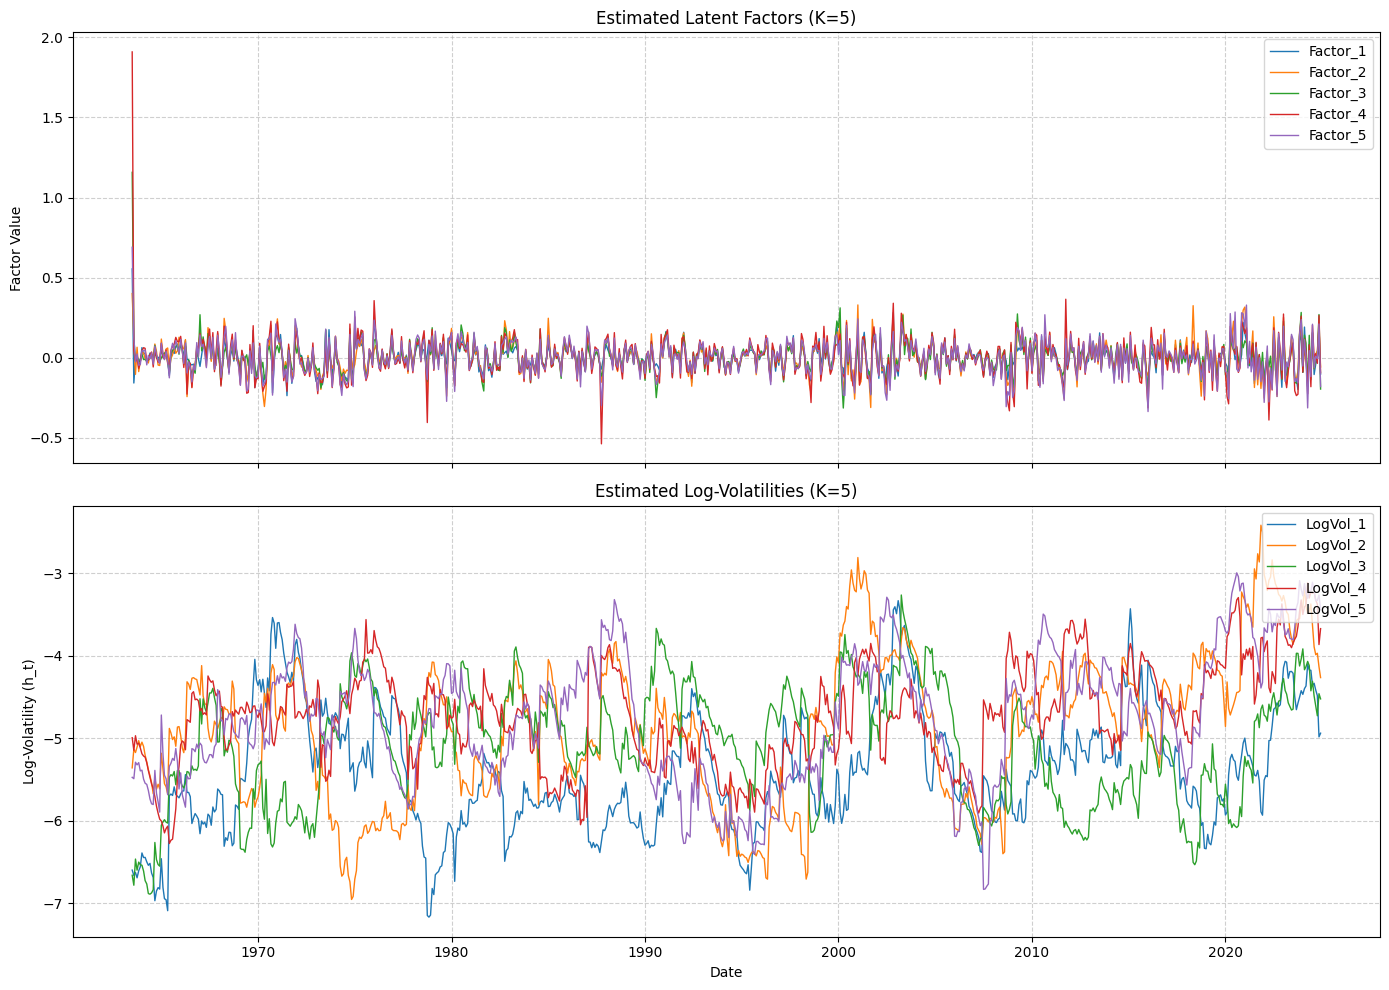

In [15]:
# --- Plotting ---
num_states = K # Number of factors OR log-vols to plot

# Create figure with 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True) # Share x-axis

# Plot Factors on the first subplot (axes[0])
axes[0].set_title(f'Estimated Latent Factors (K={K})')
for i in range(num_states):
    col_name = factor_cols[i]
    axes[0].plot(plot_df.index, plot_df[col_name], label=col_name, linewidth=1)
axes[0].set_ylabel('Factor Value')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Log-Volatilities on the second subplot (axes[1])
axes[1].set_title(f'Estimated Log-Volatilities (K={K})')
for i in range(num_states):
    col_name = logvol_cols[i]
    axes[1].plot(plot_df.index, plot_df[col_name], label=col_name, linewidth=1)
axes[1].set_ylabel('Log-Volatility (h_t)')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Common X-axis label
axes[1].set_xlabel('Date')

# Improve layout and display
plt.tight_layout()
plt.show()

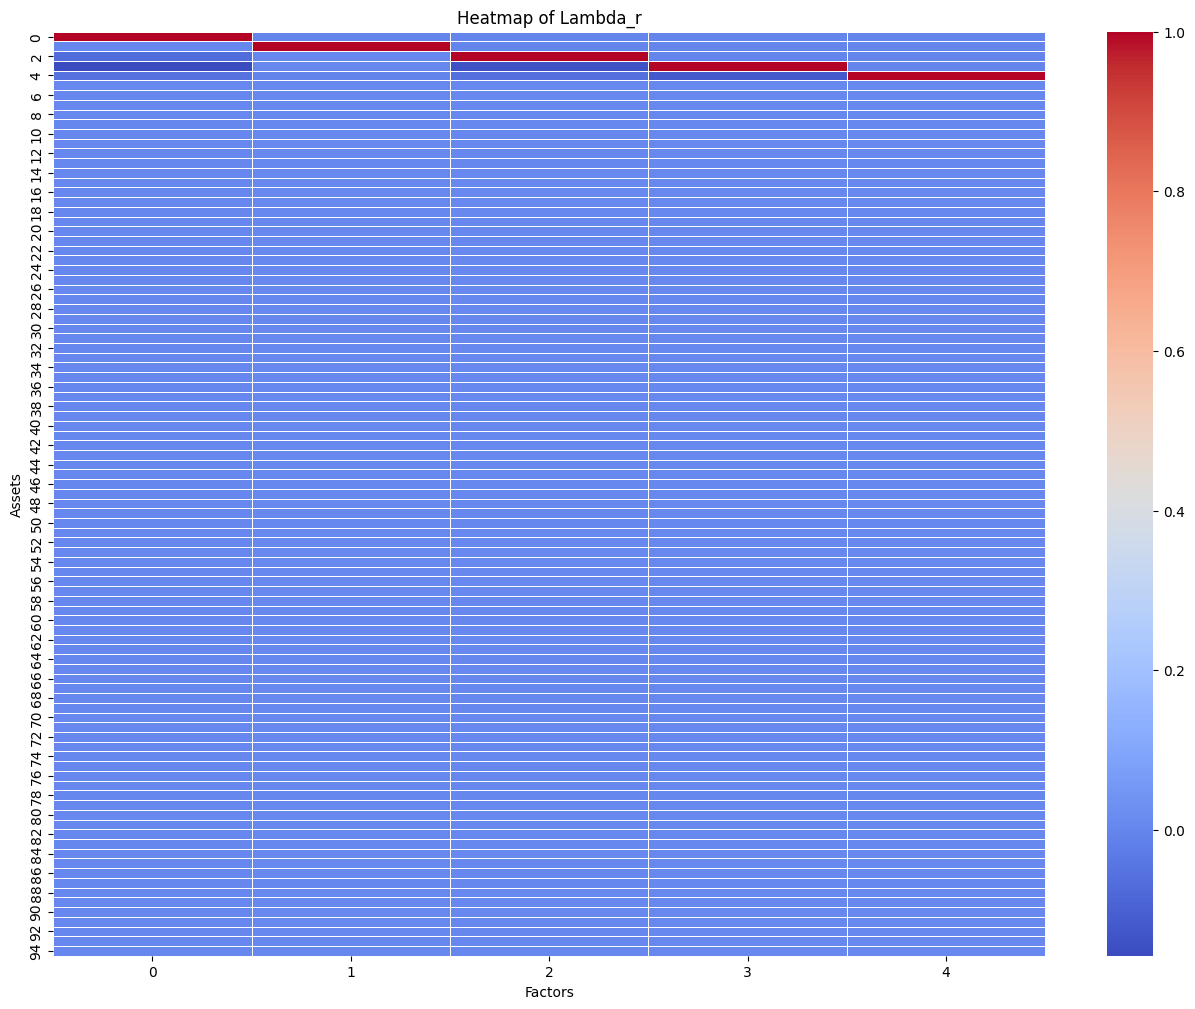

Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.50462382e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-7.06166703e-02,  1.71860675e-03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.57816135e-01,  4.92642899e-04, -1.41231933e-01,
         1.00000000e+00,  0.00000000e+00],
       [-5.68937104e-02, -6.82599368e-03, -6.26165910e-02,
        -1.20573878e-01,  1.00000000e+00],
       [ 5.13674521e-03,  6.91839982e-03,  5.51975914e-03,
         8.05703091e-03,  8.01886819e-03],
       [ 4.96072464e-03,  6.77291359e-03,  5.49113239e-03,
         7.93623872e-03,  7.88838920e-03],
       [ 5.38078622e-03,  7.08315706e-03,  5.86754052e-03,
         8.52991644e-03,  8.59254674e-03],
       [ 5.49946494e-03,  7.36294678e-03,  5.98624183e-03,
         8.80330340e-03,  8.70901678e-03],
       [ 4.70533451e-03,  6.37103334e-03,  5.27312225e-03,
         7.57141704e-03

In [16]:
#Create a heatmap of factor loadings lambda_r
import matplotlib.pyplot as plt
import seaborn as sns
lambda_r=bif_params.lambda_r

# Create a heatmap of lambda_r
plt.figure(figsize=(16, 12))
sns.heatmap(bif_params.lambda_r, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Lambda_r')
plt.xlabel('Factors')
plt.ylabel('Assets')
plt.show()
bif_params.lambda_r

variance of each z-series (should be ~1): 9.389727562142802

first five LJ p-values (lag 10):
[
    np.float64(1.0),
    np.float64(0.9999999999999788),
    np.float64(8.397477746945727e-13),
    np.float64(1.0),
    np.float64(0.840020810118187)
]

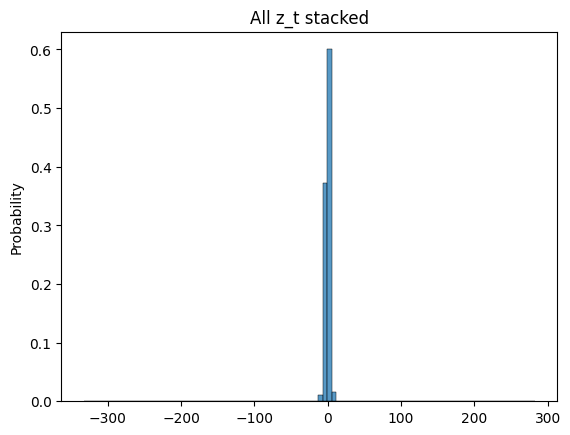

In [17]:
# After you rebuild z_t with Σ_{t|t-1} ...

print('variance of each z-series (should be ~1):',
      standardized_residuals_bif_df.var().mean())

print('first five LJ p-values (lag 10):',
      [acorr_ljungbox(standardized_residuals_bif_df[col]**2,
                      lags=[10]).iloc[0,1]
       for col in standardized_residuals_bif_df.columns[:5]])

# visual check
import matplotlib.pyplot as plt, seaborn as sns
sns.histplot(standardized_residuals_bif_df.values.flatten(), bins=100, stat='probability')
plt.title('All z_t stacked'); plt.show()


In [18]:
import numpy as np
from scipy.stats import kurtosis
from statsmodels.stats.stattools import jarque_bera
from scipy.special import digamma
from scipy.optimize import brentq

# --- POST-HOC STUDENT-t CHECK ---------------------------------------------
# 1. Flatten and clean residuals
z = standardized_residuals_bif_post_burn.values.flatten()
z = z[~np.isnan(z)]

# 2. Define score function for ν MLE
def score(nu, z):
    term1 = np.log1p(z**2 / nu).mean()
    term2 = (
        digamma((nu + 1) / 2)
        - digamma(nu / 2)
        + np.log(nu / 2)
        - np.log((nu + 1) / 2)
    )
    return term1 - term2

# 3. Estimate ν via root finding with fallback
try:
    nu_hat = brentq(score, 2.1, 200, args=(z,))
except ValueError:
    # Method-of-Moments fallback: excess kurtosis = 6/(ν-4)
    k_ex = kurtosis(z, fisher=True)
    nu_hat = 6.0 / k_ex + 4.0

print(f"Estimated ν = {nu_hat:.2f}")

# 4. Compare excess kurtoses
k_emp = kurtosis(z, fisher=True)
k_t   = np.inf if nu_hat <= 4 else 6 / (nu_hat - 4)
print(f"Empirical excess kurtosis : {k_emp:.3f}")
print(f"Implied by t({nu_hat:.1f})   : {k_t:.3f}")

# 5. Jarque–Bera p-value under Gaussian
jb_stat, jb_p, skew, kurt = jarque_bera(z)
print(f"JB p-value (Gaussian)     : {jb_p:.4f}")

# 6. Monte-Carlo for JB p-values under t(ν̂)
rng = np.random.default_rng(0)
sim_p = []
for _ in range(10_000):
    zs = rng.standard_t(df=nu_hat, size=z.size)
    _, p, _, _ = jarque_bera(zs)
    sim_p.append(p)

print(f"Median JB p-value (t)     : {np.median(sim_p):.4f}")


Estimated ν = 4.00

Empirical excess kurtosis : 3018.685

Implied by t(4.0)   : 3018.685

JB p-value (Gaussian)     : 0.0000

Median JB p-value (t)     : 0.0000

In [19]:
import numpy as np
from statsmodels.stats.stattools import jarque_bera

# residuals_df = standardized_residuals_bif_post_burn  # your DataFrame
alpha    = 0.05
nu_hat   = 5.27         # from your earlier estimation
n_reps   = 1000         # number of MC draws per series
rng      = np.random.default_rng(12345)

pass_norm = 0.0
pass_t    = 0.0

# Loop over each of the 95 series
for col in residuals_df.columns:
    data = residuals_df[col].dropna().values
    n    = data.size

    # 1) Normal test on the real series
    _, p_norm, _, _ = jarque_bera(data)
    pass_norm += (p_norm > alpha)

    # 2) MC under t(ν̂)
    # Draw (n_reps × n) array of t variates
    sims = rng.standard_t(df=nu_hat, size=(n_reps, n))
    # Compute JB p-values for each replicate
    pvals = np.array([jarque_bera(s)[1] for s in sims])
    # Fraction of those M-C series that pass at 5%
    pass_t += (pvals > alpha).mean()

# Convert counts to rates
pass_norm_rate = pass_norm / len(residuals_df.columns)
pass_t_rate    = pass_t    / len(residuals_df.columns)

print(f"Per‐series JB pass‐rate (Gaussian) : {pass_norm_rate:.1%}")
print(f"Per‐series JB pass‐rate (t({nu_hat:.1f})) : {pass_t_rate:.1%}")


Per‐series JB pass‐rate (Gaussian) : 0.0%

Per‐series JB pass‐rate (t(5.3)) : 0.1%